# Module 03 Practicum:  ImageClustering using PCA, Kmeans, DBSCAN

In this module you will be generating this graph, and describing that it means in terms os sanity checking your clusters, and what it means in terms of feature dimensions

![Assets/dbscan_graph.png](Assets/dbscan_graph.png)


## Learning Objectives

* Explore and interpret the image dataset

* Apply Intel® Extension for Scikit-learn* patches to Principal Components Analysis (PCA), Kmeans,and DBSCAN algorithms
* **Synthesize** your understanding- searching for ways to patch or unpatch any applicable cells to maximize the performance of each cell

# Practicum:

- Analyze each cell looking for places to patch or unpatch as needed to maximize the performace of each cell.
- Apply a patching strategy that applies the patch to every algorithm optimized by patching.



<a id='Back_to_Sections'></a>

## Sections

- _Code:_ [Read Images](#Define-image-manipulation-and-Reading-functions)
- _Code:_ [Submit batch_clustering_Streamlined.py as a batch job](#Submit-batch_clustering_Streamlined.py-as-a-batch-job)
- _Code:_ [Plot Kmeans using GPU results](#Plot-Kmeans)
- _Code:_ [Plot DBSCAN using GPU results](#Plot-DBSCAN)

# Dependencies required:

- pip install pillow
- pip install seaborn

# Data Description

This data represent wildlife images taken by the author of thisnotebook. It is an UNBALANCED set of images of Collared Lizards, Pelicans, and Seascapes. The images are shot in various white balances to make clustering a challenge.  Additionally, the data are imbalalanced so that some lizrds were photographed in bright light, and some in shade. The goal is to perform clustering to aid eventual clsasification for use in a CNN semi-supervised learning exercise

The iamges are read in from a folder, and one by one that are reshaped to a single row with perhaps 60,000 columns (one image now per row). After they are assembled into a NumPy array there are scaled to zero mean, unit standard deviation to aid the Prinicpal Component step to have somewhat similar scale ranges.

The image array is tranaformed via PCA with 2 to 6 principal components shich changes the shape of the data we feed to kmeans or DBSCAn to n x c where c is the number of principal components we desire (likely in range from 2 to 6)

Then the data is plotted in a Seaborn pairplot to allow us to spot clusters visually, by which ever combo of principal components.

We use KMeans or DBSCAN to help automaticllay select which images belong to which cluster as reppresented by the color of the dots.

We also display an image grid of the clustered images to see if simialr images are clustered together to meet with our intuition.


In [1]:
from __future__ import print_function
data_path = ['data']

# Notebook time start
from datetime import datetime

start_time = datetime.now()

current_time = start_time.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 17:04:40


# Define image manipulation and Reading functions

You do not have to patch code inside the lab.Read_Transform_Images script

In [2]:

from lab.Read_Transform_Images import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<a id='Actually-read-the-images'></a>
# Actually read the images

- [Back to Sections](#Back_to_Sections)

In [3]:
resultsDict = {}
#resultsDict = Read_Transform_Images(resultsDict,imagesFilenameList = imagesFilenameList)
resultsDict = Read_Transform_Images(resultsDict,path = 'data/')


Running Read_Transform_Images on CPU: 


# Display ImageGrid Random Sampling

This should give an idea of how closely or differently the various images appear. Notice that some of the collard lizard images have much differnet white balance and this will affect the clustering. For this dataset the images are clustered based on the similarity in RGB colorspace only.

You should notice several similar images of:
- Dark white balance lizards
- Light white balance lizards
- Skyscape with pelicans
- Seascapes with surf

Ccan an algorithm we design find clustering values in rough agreement to the above?

(24, 480, 640, 3)


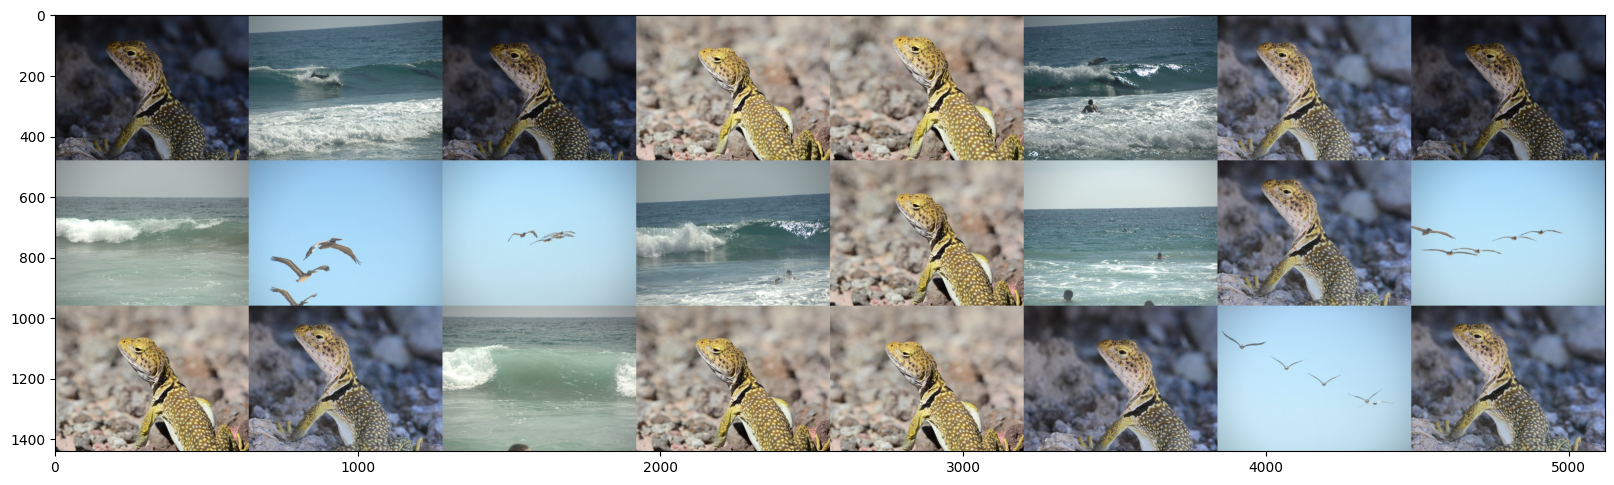

In [4]:
img_arr = []
ncols = 8
imageGrid=(ncols,3)
for pil in random.sample(resultsDict['list_PIL_Images'], imageGrid[0]*imageGrid[1])  :
    img_arr.append(np.array(pil))
#displayImageGrid(img_arr, imageGrid=imageGrid)
displayImageGrid2(img_arr, ncols=ncols)

## Create a Cell in the Style of a main() Python Script

This is a preperatory step for a later  when we qsub code to another compute node that has a GPU resiing in it

In this case we run the code on a CPU, so we can become familiar with the results for comparison to later GPU results

In [5]:
%%time
# %load batch_clustering_Streamlined.py
# batch_clustering_Streamlined.py

#===============================================================================
# Copyright 2014-2022 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#===============================================================================

import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
from PIL.Image import Image as PilImage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd
import random
import operator
import seaborn as sns

from lab.Read_Transform_Images import ReshapeShortFat
from lab.Read_Transform_Images import Read_Transform_Images
from lab.Read_Transform_Images import displayImageGrid
from lab.Read_Transform_Images import NumpyEncoder


def main():
    #from sklearn.decomposition import PCA

    resultsDict = {}
    #resultsDict = Read_Transform_Images(resultsDict)
    resultsDict = Read_Transform_Images(resultsDict,path = 'data/')
    
    knee = 6
    EPS = 220
    n_components = 3
    n_samples = 3
    NP_images_STD = resultsDict['NP_images_STD'] # images as numpy array

    del resultsDict
    pca = PCA(n_components=n_components)
    data = NP_images_STD
    PCA_fit_transform = pca.fit_transform(data) 
    print(PCA_fit_transform[:3,:])
    k_means = KMeans(n_clusters = knee, init='random')
    db = DBSCAN(eps=EPS, min_samples = n_samples).fit(PCA_fit_transform)
    km = k_means.fit(PCA_fit_transform)     
        
    print('db.labels_ ', db.labels_)
    print('km.labels_ ',km.labels_)
    
    PCA_table = pd.DataFrame(PCA_fit_transform) 
    PCA_table.to_csv('data/PCA_fit_transform.csv', index=False )
    db_table = pd.DataFrame(db.labels_) 
    db_table.to_csv('data/db_labels.csv', index=False )    
    km_table = pd.DataFrame(km.labels_) 
    km_table.to_csv('data/km_labels.csv', index=False )
    counts_db, bins_db = np.histogram(db.labels_, bins = knee)
    counts_db_table = pd.DataFrame(counts_db)
    counts_db_table.to_csv('data/counts_db.csv', index=False ) 
    bins_db_table = pd.DataFrame(bins_db)
    bins_db_table.to_csv('data/bins_db.csv', index=False ) 
    
    counts_km, bins_km =np.histogram(k_means.labels_, bins = knee)
    counts_km_table = pd.DataFrame(counts_km)
    counts_km_table.to_csv('data/counts_km.csv', index=False ) 
    bins_km_table = pd.DataFrame(bins_km)
    bins_km_table.to_csv('data/bins_km.csv', index=False ) 
    
    print("All good inside main\n")
    
    return 

if __name__ == "__main__":
    main()
    #print("km_list: ", resultsDict['km_list'][0:2])
    print('All looks good!\nRun 03_Plot_GPU_Results.ipynb to graph the results!')

# Notices & Disclaimers 

# Intel technologies may require enabled hardware, software or service activation.
# No product or component can be absolutely secure.

# Your costs and results may vary.

# © Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
# *Other names and brands may be claimed as the property of others.


Running Read_Transform_Images on CPU: 
[[1426.1914    -41.124447  -48.421364]
 [1429.121     -39.60567   -52.974922]
 [1433.8726    -38.272617  -66.05374 ]]
db.labels_  [ 0  0  0  1  1  1  1  1  1  2  2  2  2  2  2 -1 -1  3 -1 -1  3  3  4  4
  4  4]
km.labels_  [3 3 3 5 5 5 5 5 5 0 0 0 0 0 0 2 1 1 2 2 1 1 4 4 4 4]
All good inside main

All looks good!
Run 03_Plot_GPU_Results.ipynb to graph the results!
CPU times: user 22.7 s, sys: 1.33 s, total: 24 s
Wall time: 3.14 s


Unpatched
- CPU times: user 16 s, sys: 1.08 s, total: 17.1 s
- Wall time: 1.73 s

In [6]:
%%time
path = '../03_Applied_to_Image_Clustering_CPU/data/'
resultsDict = {}
resultsDict = Read_Transform_Images(resultsDict, path=path)

knee = 6
EPS = 230
n_components = 3
n_samples = 3
    
pca = PCA(n_components=n_components)
data = resultsDict['NP_images_STD']
PCA_fit_transform = pca.fit_transform(data) 
k_means = KMeans(n_clusters = knee, init='random')
db = DBSCAN(eps=EPS, min_samples = n_samples).fit(PCA_fit_transform)
km = k_means.fit(PCA_fit_transform) 


Running Read_Transform_Images on CPU: 
CPU times: user 15.8 s, sys: 1.19 s, total: 17 s
Wall time: 1.83 s


Unpatched
 - CPU times: user 17.7 s, sys: 996 ms, total: 18.7 s
- Wall time: 1.69 s

<a id='Plot-Kmeans'></a>
# Plot Kmeans Clusters 

Plot a histogram of the using GPU results
-  [Back to Sections](#Back_to_Sections)

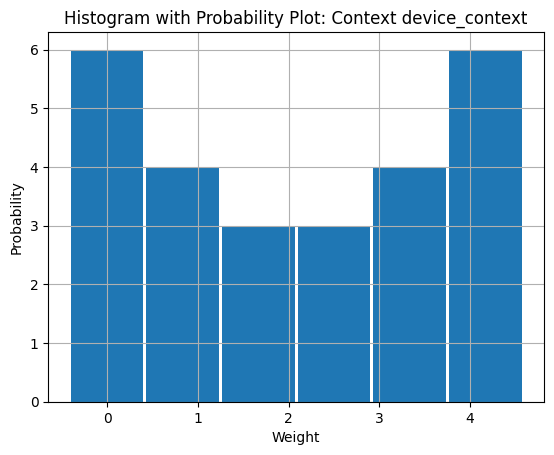

In [7]:
#resultsDict = Compute_kmeans_db_histogram_labels(resultsDict, knee = 6, gpu_available = gpu_available) #knee = 5
counts = np.asarray(pd.read_csv('data/counts_km.csv'))
bins = np.asarray(pd.read_csv('data/bins_km.csv'))
#counts = np.asarray(resultsDict['counts'])
#bins = np.asarray(resultsDict['bins'])
plt.xlabel("Weight")
plt.ylabel("Probability")
plt.title("Histogram with Probability Plot: Context {}".format('device_context'))
slice = min(counts.shape[0], bins.shape[0])
plt.bar(bins[:slice,0],counts[:slice,0])
plt.grid()
plt.show()

# Display Similar Images

Visually compare image which have been clustered by the allgorithm.

You may be surpirsed at the cluster grouping - what kmeans finds simialr or dissimilar based only on RGB colors

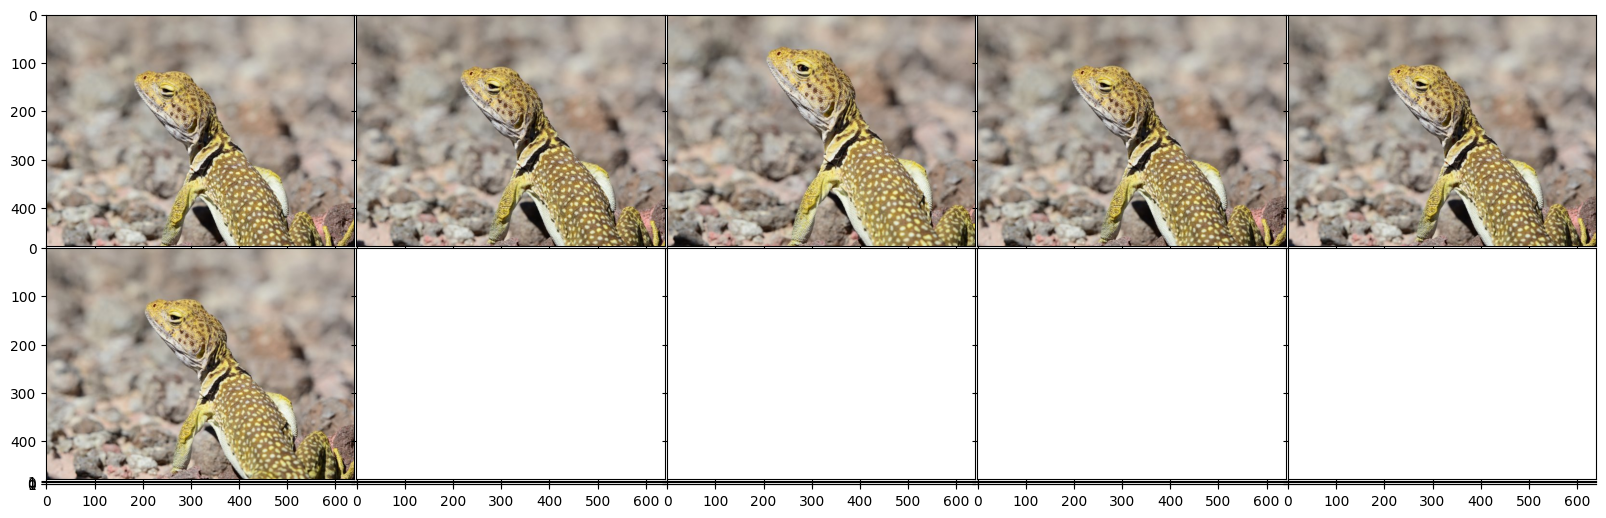

In [8]:
clusterRank = 0
km_labels = np.asarray(pd.read_csv('data/km_labels.csv'))
d = {i:cts for i, cts in enumerate(np.asarray(pd.read_csv('data/counts_km.csv')))}
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)

id = sorted_d[clusterRank][0] 
indexCluster = np.where(km_labels == id  )[0].tolist()
img_arr = []
for idx in indexCluster:
    img_arr.append(np.array((resultsDict['list_PIL_Images'][idx])))
img_arr = np.asarray(img_arr)
displayImageGrid(img_arr)

In [9]:
sorted_d

[(0, array([6])),
 (5, array([6])),
 (1, array([4])),
 (4, array([4])),
 (2, array([3])),
 (3, array([3]))]

# Plot Seaborn Kmeans Clusters

Indicates numbers of images that are close in color space

<Figure size 800x800 with 0 Axes>

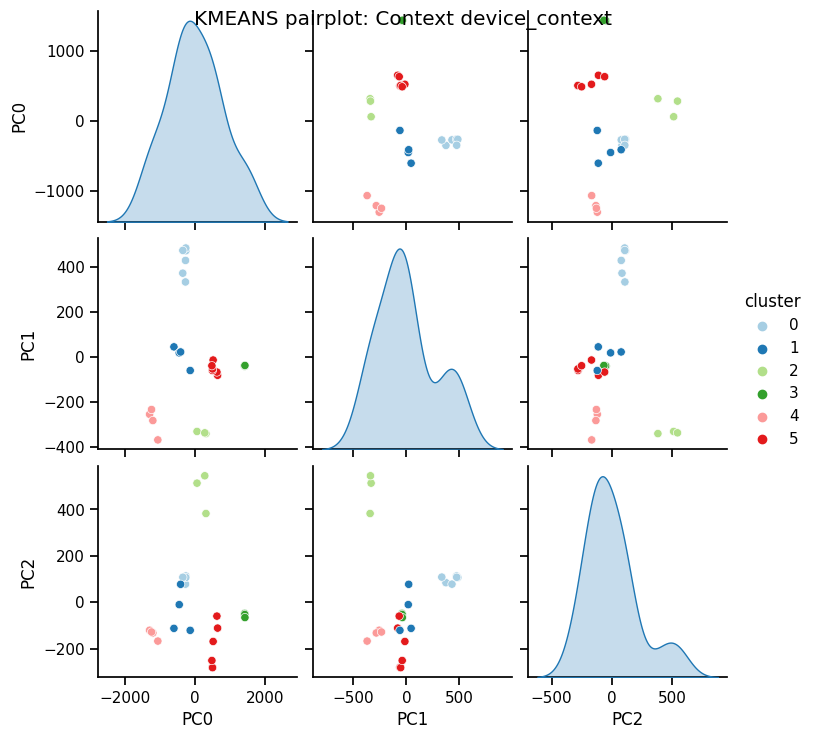

In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
n_components = 3

PCA_table = pd.read_csv('data/PCA_fit_transform.csv')
columns = ['PC{:0d}'.format(c) for c in range(n_components)]
data = pd.DataFrame(np.asarray(PCA_table)[:,:n_components], columns = columns)
#k_means = resultsDict['model']
data['cluster'] = km_labels
data.head()

columns.append('cluster')
plt.figure(figsize=(8,8))

sns.set_context('notebook');
g = sns.pairplot(data[columns], hue="cluster", palette="Paired", diag_kws=dict(hue=None));
g.fig.suptitle("KMEANS pairplot: Context {}".format('device_context'));

In [11]:
data

,PC0,PC1,PC2,cluster
0,1426.191400,-41.124447,-48.421364,3
1,1429.121000,-39.605670,-52.974922,3
2,1433.872600,-38.272617,-66.053740,3
3,648.670600,-82.008430,-111.504720,5
4,628.661500,-67.583780,-59.843666,5
5,520.274660,-14.026232,-169.068950,5
6,497.873100,-60.441190,-280.615080,5
7,503.208040,-53.676266,-281.944340,5
8,484.660400,-39.363323,-251.131420,5
9,-352.287630,372.998960,84.171486,0


# Find DBSCAN EPS parameter

**We need to know roughly the size of EPS to try** 

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

EPS: "epsilon" value in sklearn is the maximum distance between two samples for one to be considered as in the neighborhood of the other.

At least a first value to start. We are using kNN to find distances commonly occuring in the dataset. Values of EPS below this threshold distance will be considered as lyig within a given cluster. This means we should look for long flat plateaus and read the y coordinate off the kNN plot to get a starting value for EPS.

Different datasets can have wildly different sweet spots for EPS. Some datasets require EPS values of .001 other datasets may work best with values of EPS of several thousand. We use this trick to get in the right or approximate neighborhood of the EPS.


CPU times: user 29.7 ms, sys: 4.12 ms, total: 33.8 ms
Wall time: 81.7 ms


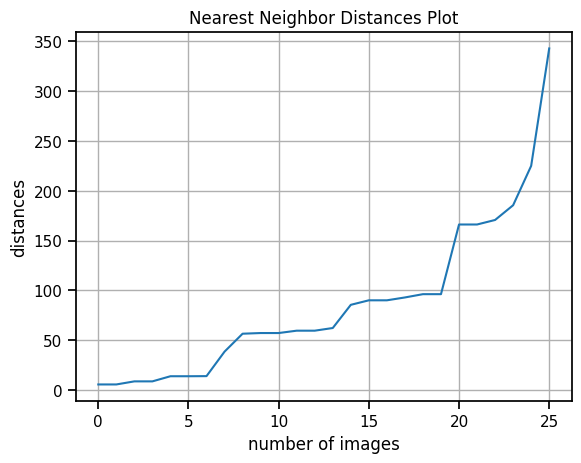

In [12]:
%%time
from sklearn.neighbors import NearestNeighbors

PCA_images = data

neighbors = NearestNeighbors(n_neighbors=2)
#X = StandardScaler().fit_transform(PCA_images)
neighbors_fit = neighbors.fit(PCA_images)
distances, indices = neighbors_fit.kneighbors(PCA_images)

distances = np.sort(distances, axis=0)
plt.xlabel('number of images')
plt.ylabel('distances')
plt.title('Nearest Neighbor Distances Plot')
plt.plot(distances[:,1])
plt.grid()

Unpatched

- CPU times: user 17.2 ms, sys: 85 µs, total: 17.2 ms
- Wall time: 13.8 ms

# Use DBSCAN to find clusters

Use initial estiamtes from KNN above (find elbow) to given initial trial for DBSCAN EPS values 

In the plot above, there is a plateau in the y values somewherre near 350 indicating that a cluster distance (aka EPS) might work well somewhere near this value. We used this value in the batch_clustering_Streamlined.py file when computing DBSCAN.

**EPS:** Two points are  neighbors if the distance between the two points is below a threshold.
**n:** The minimum number of neighbors a given point should have in order to be classified as a core point. 
The point itself is included in the minimum number of samples.

# Below: Find EPS That Minimizes Outliers

CPU times: user 12.7 s, sys: 1.05 s, total: 13.7 s
Wall time: 1.22 s


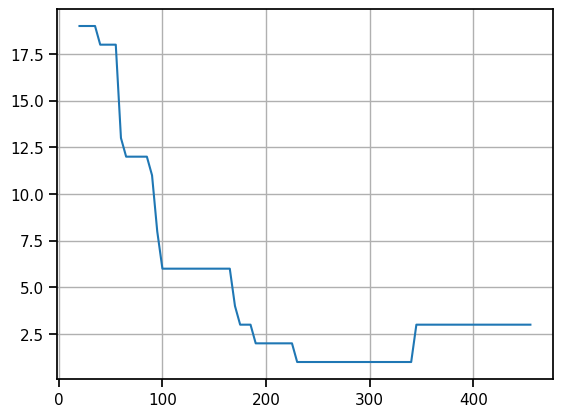

In [13]:
%%time

pca = PCA(n_components=n_components)
data = resultsDict['NP_images_STD']
PCA_fit_transform = pca.fit_transform(data) 
n_samples = 2 # we'll say that you have to have at least 2 points in a set to call it a cluster

R = [i for i in range(20,460, 5)] # Range of EPS values to try
v = np.zeros([len(R), 2]) # empty array
idx = 0
plotData = np.zeros([len(R),2])
for eps in  R:
    db = DBSCAN(eps = eps, min_samples = n_samples).fit(PCA_fit_transform)
    counts = np.unique(db.labels_ , return_counts=True)
    plotData[idx,0] = eps
    plotData[idx,1] = counts[1][0]
    idx += 1
plt.plot(plotData[:,0], plotData[:,1])
plt.grid()

Unpatched

- CPU times: user 12.4 s, sys: 629 ms, total: 13 s
- Wall time: 1.18 s

In [14]:
%%time
#%%write_and_run    lab/compute_DBSCANClusterRank.py 
def compute_DBSCANClusterRank(n_samples = 3, n_components = 3, EPS = 230 ):
    pca = PCA(n_components=n_components)
    data = resultsDict['NP_images_STD']
    PCA_fit_transform = pca.fit_transform(data) 
    db = DBSCAN(eps=EPS, min_samples = n_samples).fit(PCA_fit_transform)

    counts = np.unique(db.labels_ , return_counts=True)
    d = {k:v for k, v in sorted(zip(counts[0], counts[1]), reverse=True, key=operator.itemgetter(1))}
    sorted_d = {k:v for k, v in sorted(zip(counts[0], counts[1]), reverse=True, key=operator.itemgetter(1))}
    return db, counts, sorted_d, PCA_fit_transform
data
n_components = 3
columns = ['PC{}'.format(i) for i in range(n_components)]
EPS = 230
db, counts, sorted_d, PCA_fit_transform = compute_DBSCANClusterRank(n_samples = 3, n_components = n_components, EPS = EPS)
PCAdf = pd.DataFrame(PCA_fit_transform, columns = columns)
PCAdf['cluster'] = db.labels_
print(sorted_d)

{1: 6, 2: 6, 5: 4, 0: 3, 3: 3, 4: 3, -1: 1}
CPU times: user 11.5 s, sys: 714 ms, total: 12.2 s
Wall time: 1.09 s


Unpatched

- CPU times: user 11.5 s, sys: 680 ms, total: 12.2 s
- Wall time: 1.09 s



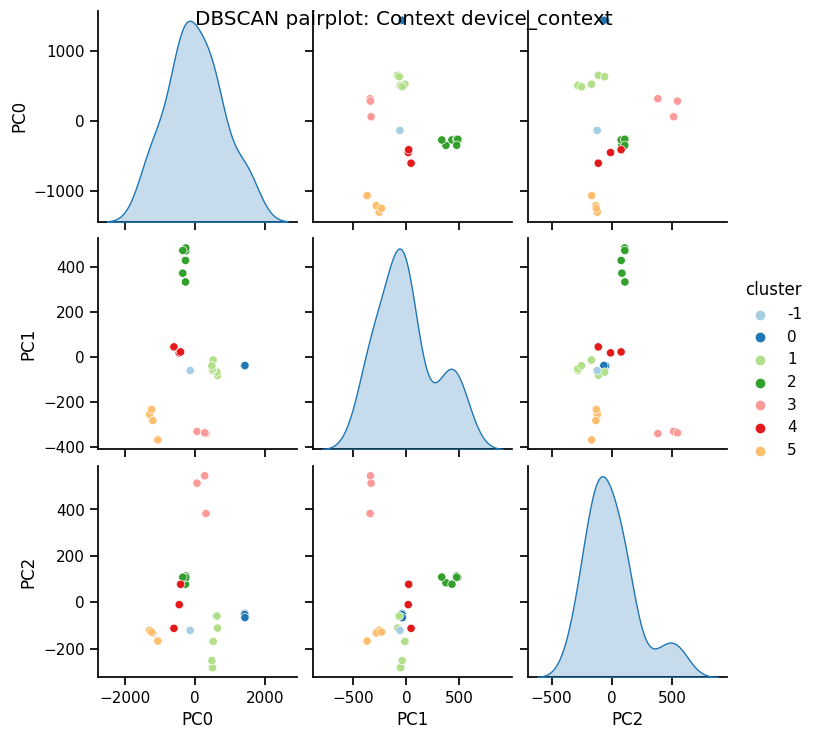

In [15]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set_context('notebook');
g = sns.pairplot(PCAdf, hue="cluster", palette="Paired", diag_kws=dict(hue=None));
g.fig.suptitle("DBSCAN pairplot: Context {}".format('device_context'));

# Print Filenames of Outliers

In [16]:
print('Outlier/problematic images are: \n', 
      [resultsDict['imagesFilenameList'][f].split('/')[-1] for f in list(PCAdf[PCAdf['cluster'] == -1].index)]
     )

Outlier/problematic images are: 
 ['Ocean Waves (2).jpg']


<a id='Plot-DBSCAN'></a>
# DBSCAN Cluster Plots

Plot a histogram of the using GPU results
- [Back to Sections](#Back_to_Sections)

 

To indicate numbers of images in each cluster. color each point by its membership in a cluster

**Why read the counts and bins for DB from the csv from earlier?**

We will read the values from those saved earlier into a couple of csv files. THis is so later, when we modify for use with GPU on another node in the cluster, we can plot the results from that node.

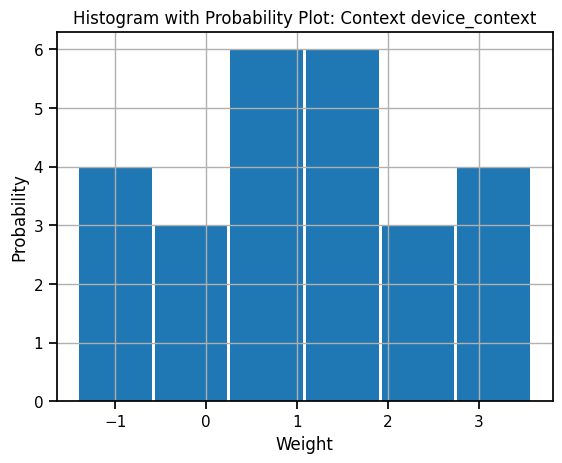

In [17]:
#resultsDict = Compute_kmeans_db_histogram_labels(resultsDict, knee = 6, gpu_available = gpu_available) #knee = 5
counts = np.asarray(pd.read_csv('data/counts_db.csv'))
bins = np.asarray(pd.read_csv('data/bins_db.csv'))
#counts = np.asarray(resultsDict['counts'])
#bins = np.asarray(resultsDict['bins'])
plt.xlabel("Weight")
plt.ylabel("Probability")
plt.title("Histogram with Probability Plot: Context {}".format('device_context'))
slice = min(counts.shape[0], bins.shape[0])
plt.bar(bins[:slice,0],counts[:slice,0])
plt.grid()
plt.show()

### We sort the dictionary containing the idx and counts of each cluster

We call the most frequently encoutered cluster, ClusterRank 0.  The next most frequently encoutered cluster,, is ClusterRank1, etc

Once we know the most common clusters, we can arrange the photos in a grid so we can see iamge clusters ot get a visual sense of similarity

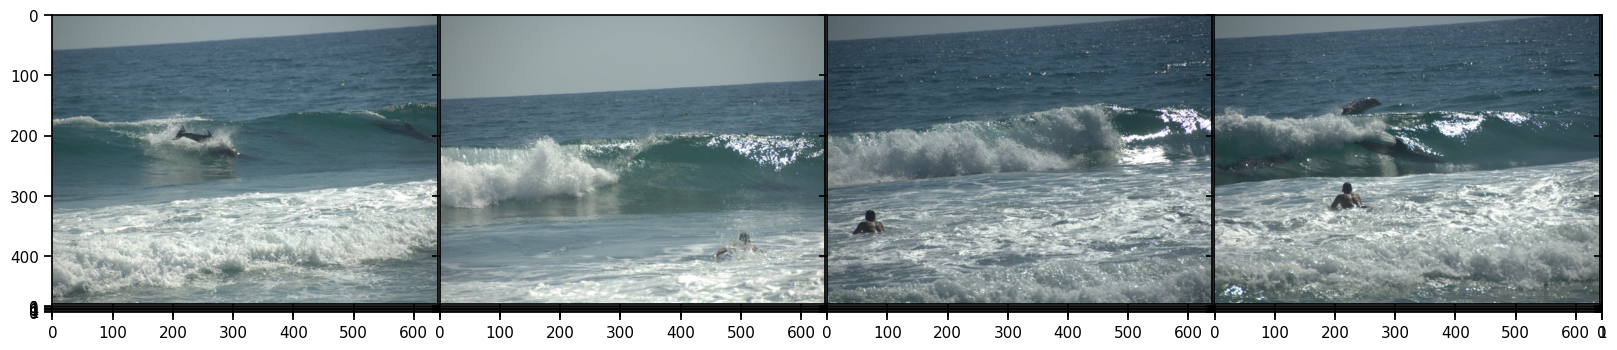

id:  -1


In [18]:
clusterRank = 2
db_labels = np.asarray(pd.read_csv('data/db_labels.csv'))
d = {i:cts for i, cts in enumerate(np.asarray(pd.read_csv('data/counts_db.csv')))}
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)

id = sorted_d[clusterRank][0] - 1
indexCluster = np.where(db_labels == id  )[0].tolist()
img_arr = []
for idx in indexCluster:
    img_arr.append(np.array((resultsDict['list_PIL_Images'][idx])))
img_arr = np.asarray(img_arr)
displayImageGrid(img_arr)
print('id: ',id)

## Notes:

Did you notice any differences in timing between patched versus unpatched?

If you exerpereinced marginal or no performance improvements, What do you think explains your observation?


# Final Thoughts and next steps...

You may have noticed how difficult it is to get decent clustering on even 30 or 40 images using only RGB or HSV as the feature set
.
If all the images are well separated in either RGB, or HSV color space, then these features are useful for clustering.

However, a suggested next step—or next training—would be to encode the data differently. Perhaps using image classification with VGG16, but removing the last layer as a preprocess prior to k-means or DBSCAN.


.

# Notices & Disclaimers 

Intel technologies may require enabled hardware, software or service activation.
No product or component can be absolutely secure.

Your costs and results may vary.

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
*Other names and brands may be claimed as the property of others.



In [19]:
print("All Done")

All Done
